In [ ]:
# IMport required libraries
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from random import randint
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.layers import Activation, Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

In [ ]:
#To mount Google Drive on runtime to read and write the files in the drive.
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import required libraries
%cd /content/gdrive/MyDrive/EE258_NN
# function to load images and respective labels
def load_img(directory):
  Images = []
  Labels = []
  for labels in os.listdir(directory):
    if labels == 'angry':
      label = 0
    elif labels == 'disgust':
      label = 1
    elif labels == 'fear':
      label = 2
    elif labels == 'happy':
      label = 3
    elif labels == 'neutral':
      label = 4
    elif labels == 'sad':
      label = 5
    elif labels == 'surprise':
      label = 6
    for image_file in os.listdir(directory+labels):
      image = cv2.imread(directory+labels+'/'+image_file, cv2.IMREAD_GRAYSCALE) #  add labels to the images which is in gray scale.
      image = cv2.resize(image, (48,48))
      #image /= 255 Normalise
      Images.append(image)
      Labels.append(label)
  return shuffle(Images, Labels, random_state = 40)

def get_classlabel(class_code):
  labels = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',6:'surprise'}
  return labels[class_code]

/content/gdrive/MyDrive/EE258_NN


In [ ]:
# load the images from the gdrive folder seperately for test and train
train_Img_data, train_Label_data = load_img('/content/gdrive/MyDrive/EE258_NN/train/')
test_Img_data, test_Label_data = load_img('/content/gdrive/MyDrive/EE258_NN/test/')

In [ ]:
## Saving the data as numpy array for faster reloads
train_Img_np = np.array(train_Img_data)
train_Label_np = np.array(train_Label_data)
np.save('/content/gdrive/MyDrive/EE258_NN/train_new/train_Images.npy',train_Img_np) 
np.save('/content/gdrive/MyDrive/EE258_NN/train_new/train_Labels.npy',train_Label_np)
test_Img_np = np.array(test_Img_data)
test_Label_np = np.array(test_Label_data)
np.save('/content/gdrive/MyDrive/EE258_NN/test_new/test_Images.npy',test_Img_np) 
np.save('/content/gdrive/MyDrive/EE258_NN/test_new/test_Labels.npy',test_Label_np)

In [ ]:
## Loading the data from numpy array
train_loaded_images = np.load('/content/gdrive/MyDrive/EE258_NN/train_new/train_Images.npy')
train_loaded_labels = np.load('/content/gdrive/MyDrive/EE258_NN/train_new/train_Labels.npy')
test_loaded_images = np.load('/content/gdrive/MyDrive/EE258_NN/test_new/test_Images.npy')
test_loaded_labels = np.load('/content/gdrive/MyDrive/EE258_NN/test_new/test_Labels.npy')

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4965, 5: 4830, 6: 3171}
(28709, 48, 48)
(28709,)


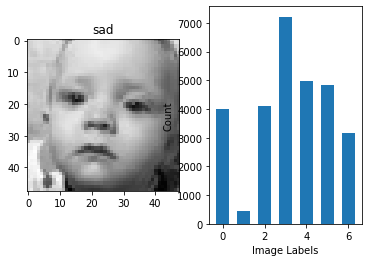

In [ ]:
# Plotting random images from the train dataset
fig,ax = plt.subplots(1,2)
for i in range(1):
  rnd_number = randint(0,len(train_loaded_labels))
  ax[i].imshow(train_loaded_images[rnd_number],cmap='gray')
  ax[i].set_title(get_classlabel(train_loaded_labels[rnd_number]))
  label_values, count = np.unique(train_loaded_labels,return_counts = True)
  distribution = dict(zip(label_values, count))
  plt.bar(list(distribution.keys()), distribution.values(),width = 0.6)
  plt.xlabel('Image Labels')
  plt.ylabel('Count')
  plt.show
print(distribution) #Print how many imgaes are there in the respective classes
print(train_loaded_images.shape) # Total number of images and image shape  
print(train_loaded_labels.shape) # Number of labels 

In [ ]:
#Print the images and labels saved as np.array
print(train_loaded_labels)
print(train_loaded_images)

[0 5 0 ... 3 3 6]
[[[ 59  65  69 ... 201 197 202]
  [ 56  77  82 ... 197 200 199]
  [ 79  85  92 ... 195 202 199]
  ...
  [ 12   8   6 ...   9  13  20]
  [ 10   8   6 ...   9  15  21]
  [ 10   9   8 ...  11  17  16]]

 [[ 92  97  65 ...  13  12  13]
  [107  67  39 ...  15  17  20]
  [ 77  43  20 ...  21  20  20]
  ...
  [ 99  96  93 ... 119 105 105]
  [ 94  97  99 ... 117 115 119]
  [ 82  94 102 ... 111 110 101]]

 [[ 53  69  48 ...  97 141 144]
  [ 64  93  46 ...  98 138 157]
  [ 59  84  43 ... 111 132 153]
  ...
  [196 204 220 ...  69  72  72]
  [212 229 236 ...  73  79 102]
  [231 234 231 ...  78 101 125]]

 ...

 [[255 255 255 ... 255 250 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 254 255 252]
  ...
  [ 22  20  24 ... 255 254 255]
  [ 25  27  21 ... 253 255 254]
  [ 18  19  18 ... 250 255 254]]

 [[239 240 238 ... 117 138 149]
  [241 238 234 ... 155 135 160]
  [239 239 237 ... 160 151 140]
  ...
  [233 241 240 ...  74  81 204]
  [233 238 239 ...  55 169 226]
  [221 225

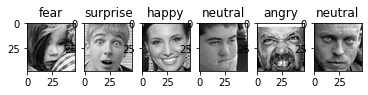

In [ ]:
# Plotting random multiple images from the train dataset 
fig,ax = plt.subplots(1,6)
#print(ax)
for i in range(6):
  rnd_number = randint(0,len(train_loaded_labels))
  ax[i].imshow(train_loaded_images[rnd_number],cmap='gray')
  ax[i].set_title(get_classlabel(train_loaded_labels[rnd_number]))
  label_values, count = np.unique(train_loaded_labels,return_counts = True)
  distribution = dict(zip(label_values, count))
  plt.show

{0: 958, 1: 111, 2: 1024, 3: 1774, 4: 1233, 5: 1247, 6: 831}
(7178, 48, 48)
(7178,)


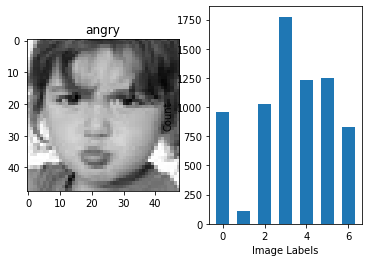

In [ ]:
# Plotting random images from the test dataset
fig,ax = plt.subplots(1,2)
for i in range(1):
  rnd_number = randint(0,len(test_loaded_labels))
  ax[i].imshow(test_loaded_images[rnd_number],cmap='gray')
  ax[i].set_title(get_classlabel(test_loaded_labels[rnd_number]))
  label_values, count = np.unique(test_loaded_labels,return_counts = True)
  distribution = dict(zip(label_values, count))
  plt.bar(list(distribution.keys()), distribution.values(),width = 0.6)
  plt.xlabel('Image Labels')
  plt.ylabel('Count')
  plt.show
print(distribution) #Print how many imgaes are there in the respective classes
print(test_loaded_images.shape) # Total number of images and image shape  
print(test_loaded_labels.shape) # Number of labels 

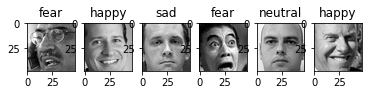

In [ ]:
# Plotting random multiple images from the test dataset
fig,ax = plt.subplots(1,6)
for i in range(6):
  rnd_number = randint(0,len(test_loaded_labels))
  ax[i].imshow(test_loaded_images[rnd_number],cmap='gray')
  ax[i].set_title(get_classlabel(test_loaded_labels[rnd_number]))
  plt.show

In [ ]:
#Print the images and labels saved as np.array
print(test_loaded_labels)
print(test_loaded_images)

[4 3 3 ... 4 4 3]
[[[253 254 208 ... 232 248 246]
  [246 255 143 ... 164 255 242]
  [252 240  85 ...  96 251 247]
  ...
  [241 244 247 ... 245 249 248]
  [241 250 246 ... 247 250 245]
  [242 245 235 ... 246 248 248]]

 [[ 32  35  40 ... 184 182 187]
  [ 48  61  44 ... 190 185 187]
  [ 72  65  38 ... 188 188 187]
  ...
  [ 86  82  85 ... 163 163 163]
  [ 89  82  81 ... 161 161 161]
  [ 90  81  78 ... 161 160 160]]

 [[ 76  84 103 ...  67  68  74]
  [ 84  99  86 ...  59  76  84]
  [ 91  87  69 ...  66  72  83]
  ...
  [ 94 115 142 ...  24  29  37]
  [ 94 106 139 ...  23  28  35]
  [101 102 132 ...  31  23  36]]

 ...

 [[199  49  54 ...  30 141 236]
  [176  44  55 ...  33  94 227]
  [130  42  55 ...  47  41 183]
  ...
  [ 45  43  42 ...  60  69  55]
  [ 46  41  38 ...  60  64  43]
  [ 49  40  37 ...  62  57  38]]

 [[124 125 130 ... 152 149 150]
  [130 125 122 ... 151 149 152]
  [126 131 118 ... 155 154 152]
  ...
  [164 162 162 ... 207 200 204]
  [163 163 162 ... 122 179 197]
  [161 165

In [ ]:
#Split the training data  into train and validation.
x_train_data, x_val_data, y_train_data, y_val_data  = train_test_split(train_loaded_images,train_loaded_labels, test_size = 1/12, random_state = 42)
print(x_train_data.shape, x_val_data.shape, y_train_data.shape, y_val_data.shape)

(26316, 48, 48) (2393, 48, 48) (26316,) (2393,)


In [ ]:
# reshaping and normalising the samples. 
x_train_data_reshaped = x_train_data.reshape(len(x_train_data), 48*48*1)
x_val_data_reshaped = x_val_data.reshape(len(x_val_data), 48*48*1)
x_test_data_reshaped = test_loaded_images.reshape(len(test_loaded_images), 48*48*1)

X_train = x_train_data_reshaped.astype('float32')/255.0
y_train = y_train_data.astype('uint')
X_val = x_val_data_reshaped.astype('float32')/255.0
y_val = y_val_data.astype('uint')
X_test = x_test_data_reshaped.astype('float32')/255.0
y_test = test_loaded_labels.astype('uint')

In [ ]:
# Creating a MLP model . Model 1
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(300, activation ="relu"))
model1.add(keras.layers.Dense(300, activation ="relu"))
model1.add(keras.layers.Dense(300, activation ="relu"))
model1.add(keras.layers.Dense(100, activation ="relu"))
model1.add(keras.layers.Dropout(0.25))
model1.add(keras.layers.Dense(7, activation = "softmax"))
sgd = SGD(learning_rate=0.001)
model1.compile(optimizer=sgd,   loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the MLP network  
model1.fit(X_train, y_train, batch_size=10, epochs=16, validation_data =(X_val, y_val))

Epoch 1/16
2632/2632 [==============================] - 10s 3ms/step - loss: 1.8163 - accuracy: 0.2485 - val_loss: 1.7844 - val_accuracy: 0.2750
Epoch 2/16
2632/2632 [==============================] - 9s 3ms/step - loss: 1.7611 - accuracy: 0.2869 - val_loss: 1.7378 - val_accuracy: 0.3021
Epoch 3/16
2632/2632 [==============================] - 9s 3ms/step - loss: 1.7192 - accuracy: 0.3198 - val_loss: 1.7101 - val_accuracy: 0.3168
Epoch 4/16
2632/2632 [==============================] - 9s 4ms/step - loss: 1.6929 - accuracy: 0.3352 - val_loss: 1.7053 - val_accuracy: 0.3184
Epoch 5/16
2632/2632 [==============================] - 9s 3ms/step - loss: 1.6754 - accuracy: 0.3445 - val_loss: 1.6729 - val_accuracy: 0.3448
Epoch 6/16
2632/2632 [==============================] - 9s 3ms/step - loss: 1.6612 - accuracy: 0.3524 - val_loss: 1.6629 - val_accuracy: 0.3464
Epoch 7/16
2632/2632 [==============================] - 9s 3ms/step - loss: 1.6475 - accuracy: 0.3607 - val_loss: 1.6922 - val_accuracy

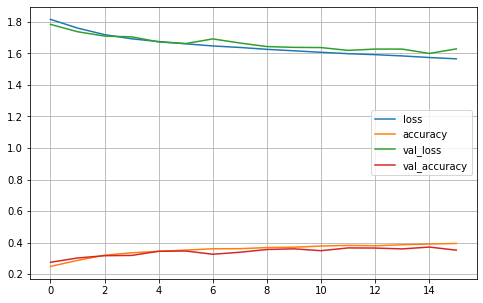

In [ ]:
# Plot the training loss and accuracy graph for model1
data = model1.history.history
pd.DataFrame(data).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
# Displaying model summary and test accuracy.
model1.summary()
loss1_train, acc1_train = model1.evaluate(X_train, y_train, verbose=0)
print('Accuracy: %.3f' % acc1_train)
loss1_test, acc1_test = model1.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc1_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 300)               691500    
                                                                 
 dense_7 (Dense)             (None, 300)               90300     
                                                                 
 dense_8 (Dense)             (None, 300)               90300     
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 7)                 707       
                                                                 
Total params: 902,907
Trainable params: 902,907
Non-tr

In [ ]:
# Confusion matrix for model 1
y_proba1 = model1.predict(X_test) 
y_pred1 = np.argmax(y_proba1,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred1, y_test))
print('Classification Report')
print(classification_report(y_pred1, y_test))

225/225 [==============================] - 1s 2ms/step
Confusion Matrix
[[  95    8   62   38   38   63   23]
 [   0    0    0    0    0    0    0]
 [  25    4   38   14   12   18   33]
 [ 495   77  477 1500  606  548  279]
 [ 134   10  170   68  373  210  104]
 [ 177   11  197  130  182  389   81]
 [  32    1   80   24   22   19  311]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.10      0.29      0.15       327
         1.0       0.00      0.00      0.00         0
         2.0       0.04      0.26      0.07       144
         3.0       0.85      0.38      0.52      3982
         4.0       0.30      0.35      0.32      1069
         5.0       0.31      0.33      0.32      1167
         6.0       0.37      0.64      0.47       489

    accuracy                           0.38      7178
   macro avg       0.28      0.32      0.26      7178
weighted avg       0.60      0.38      0.43      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# normalising the samples without reshaping.
X_train_norm = x_train_data.astype('float32')/255.0
y_train_norm= y_train_data.astype('uint')
X_val_norm = x_val_data.astype('float32')/255.0
y_val_norm = y_val_data.astype('uint')
X_test_norm = test_loaded_images.astype('float32')/255.0
y_test_norm = test_loaded_labels.astype('uint')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 128)       

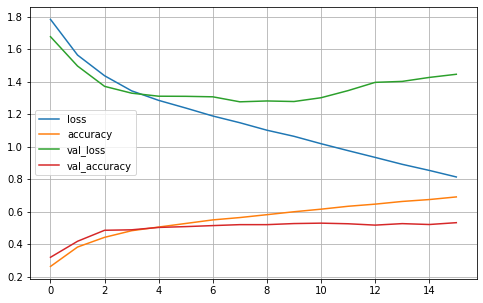

In [ ]:
# Creating a CNN model. Model 2
model2 = keras.models.Sequential()
model2.add(Conv2D(32, kernel_size = (3,3), input_shape = (48,48,1) ,activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(keras.layers.Dropout(0.25))
model2.add(keras.layers.Flatten())
model2.add(Dense(7, activation = 'softmax'))
model2.summary()
model2.compile(optimizer = 'Adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
model2.fit(X_train_norm,y_train_norm, batch_size=10, epochs = 16, validation_data=(X_val_norm,y_val_norm))
# Plot the training loss and accuracy graph for model2
pd.DataFrame(model2.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
!mkdir -p saved_model
model2.save('/content/gdrive/MyDrive/EE258_NN/train_new/cnn_v2')

In [ ]:
# obtaining train and test accuracy
loss2_train, acc2_train = model2.evaluate(X_train_norm, y_train_norm, verbose=1)
print('Accuracy: %.3f' % acc2_train)
loss2_test, acc2_test = model2.evaluate(X_test_norm, y_test_norm, verbose=1)
print('Accuracy: %.3f' % acc2_test) 

823/823 [==============================] - 4s 4ms/step - loss: 0.6582 - accuracy: 0.7603
Accuracy: 0.760
225/225 [==============================] - 1s 4ms/step - loss: 1.4271 - accuracy: 0.5265
Accuracy: 0.526


In [ ]:
# obtaining the confusion matrix for model 2
y_proba2 = model2.predict(X_test_norm) 
y_pred2 = np.argmax(y_proba2,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred2, y_test_norm))
print('Classification Report')
print(classification_report(y_pred2, y_test_norm))

225/225 [==============================] - 1s 3ms/step
Confusion Matrix
[[ 389   16  109   72  107  128   33]
 [  11   33    2    1    3    2    2]
 [  88   12  310   77   97  118  124]
 [  84    6   76 1304  117  112   65]
 [ 148   12  148  146  614  264   39]
 [ 218   31  279  141  277  605   44]
 [  20    1  100   33   18   18  524]]
Classification Report
              precision    recall  f1-score   support

           0       0.41      0.46      0.43       854
           1       0.30      0.61      0.40        54
           2       0.30      0.38      0.34       826
           3       0.74      0.74      0.74      1764
           4       0.50      0.45      0.47      1371
           5       0.49      0.38      0.43      1595
           6       0.63      0.73      0.68       714

    accuracy                           0.53      7178
   macro avg       0.48      0.53      0.50      7178
weighted avg       0.53      0.53      0.53      7178



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 128)      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/16
2632/2632 [==============================] - 15s 5ms/step - loss: 1.8143 - accuracy: 0.2492 - val_loss: 1.7833 - val_accuracy: 0.2608
Epoch 2/16
2632/2632 [==============================] - 14s 5ms/step - loss: 1.7822 - accuracy: 0.2585 - val_loss: 1.7594 - val_accuracy: 0.2674
Epoch 3/16
2632/2632 [==============================] - 14s 5ms/step - loss: 1.7517 - accuracy: 0.2855 - val_loss: 1.7412 - val_accuracy: 0.2854
Epoch 4/16
2632/2632 [==============================] - 14s 5ms/step - loss: 1.7064 - accuracy: 0.3153 - val_loss: 1.6757 - val_accuracy: 0.3443
Epoch 5/16
2632/2632 [==============================] - 14s 5ms/step - loss: 1.6637 - accuracy: 0.3436 - val_loss: 1.6466 - val_accuracy: 0.3439
Epoch 6/16
2632/2632 [==============================] - 14s 5ms/step - loss: 1.6359 - accuracy: 0.3594 - val_loss: 1.6331 - val_accuracy: 0.3460
Epoch 7/16
2632/2632 [==============================] - 14s 5ms/step - loss: 1.6043 - accuracy: 0.3770 - val_loss: 1.5888 - val_ac

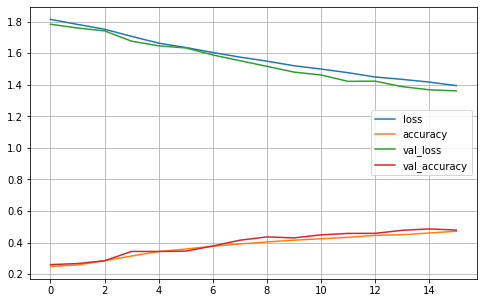

In [ ]:
#Creating a CNN model. Model 3.
model3 = keras.models.Sequential()
model3.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape= (48,48,1), data_format='channels_last', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.5))
model3.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.5))
model3.add(Dense(300, activation='relu'))
model3.add(keras.layers.Dropout(0.25))
model3.add(keras.layers.Flatten())
model3.add(Dense(7, activation='softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model3.summary()
model3.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',metrics = ['accuracy'])
model3.fit(X_train_norm,y_train_norm, batch_size=10, epochs = 16, validation_data=(X_val_norm,y_val_norm))
# Plot the training loss and accuracy graph for model3
pd.DataFrame(model3.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
!mkdir -p saved_model
model3.save('/content/gdrive/MyDrive/EE258_NN/train_new/cnn_v3')

In [ ]:
# obtaining train and test accuracy
loss3_train, acc3_train = model3.evaluate(X_train_norm, y_train_norm, verbose=1)
print('Accuracy: %.3f' % acc3_train)
loss3_test, acc3_test = model3.evaluate(X_test_norm, y_test_norm, verbose=1)
print('Accuracy: %.3f' % acc3_test) 

823/823 [==============================] - 4s 4ms/step - loss: 1.3285 - accuracy: 0.4991
Accuracy: 0.499
225/225 [==============================] - 1s 4ms/step - loss: 1.3584 - accuracy: 0.4831
Accuracy: 0.483


In [ ]:
# obtaining the confusion matrix for model 3
y_proba3 = model3.predict(X_test_norm) 
y_pred3 = np.argmax(y_proba3,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred3, y_test_norm))
print('Classification Report')
print(classification_report(y_pred3, y_test_norm))

225/225 [==============================] - 1s 4ms/step
Confusion Matrix
[[ 184   21   47   25   30   45   13]
 [   0    0    0    0    0    0    0]
 [  74    9  161   36   30   48   81]
 [ 150   18  143 1385  177  171   79]
 [ 101    7  110   62  456  152   46]
 [ 427   54  461  240  523  814  144]
 [  22    2  102   26   17   17  468]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.19      0.50      0.28       365
         1.0       0.00      0.00      0.00         0
         2.0       0.16      0.37      0.22       439
         3.0       0.78      0.65      0.71      2123
         4.0       0.37      0.49      0.42       934
         5.0       0.65      0.31      0.42      2663
         6.0       0.56      0.72      0.63       654

    accuracy                           0.48      7178
   macro avg       0.39      0.43      0.38      7178
weighted avg       0.59      0.48      0.50      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
EPOCHS = 10
BS = 32
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")
# train the network
X_train_norm_reshape = X_train_norm.reshape(-1, 48, 48, 1)
X_val_norm_reshape = X_val_norm.reshape(-1, 48, 48, 1)
X_test_norm_reshape= X_test_norm.reshape(-1, 48, 48, 1)
# using the data augmetation on the model3
model3.fit_generator(aug.flow(X_train_norm_reshape, y_train_norm, batch_size=BS),
	validation_data=(X_val_norm_reshape, y_val_norm), steps_per_epoch=len(X_train_norm_reshape) // BS,
	epochs=EPOCHS)

Epoch 1/10


<ipython-input-37-bc928e4f481a>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3.fit_generator(aug.flow(X_train_norm_reshape, y_train_norm, batch_size=BS),


822/822 [==============================] - 16s 19ms/step - loss: 1.6894 - accuracy: 0.3240 - val_loss: 1.4105 - val_accuracy: 0.4718
Epoch 2/10
822/822 [==============================] - 16s 19ms/step - loss: 1.6579 - accuracy: 0.3359 - val_loss: 1.4034 - val_accuracy: 0.4810
Epoch 3/10
822/822 [==============================] - 19s 23ms/step - loss: 1.6521 - accuracy: 0.3424 - val_loss: 1.4195 - val_accuracy: 0.4680
Epoch 4/10
822/822 [==============================] - 15s 19ms/step - loss: 1.6417 - accuracy: 0.3484 - val_loss: 1.4089 - val_accuracy: 0.4776
Epoch 5/10
822/822 [==============================] - 15s 19ms/step - loss: 1.6285 - accuracy: 0.3547 - val_loss: 1.4060 - val_accuracy: 0.4701
Epoch 6/10
822/822 [==============================] - 15s 18ms/step - loss: 1.6180 - accuracy: 0.3611 - val_loss: 1.4001 - val_accuracy: 0.4655
Epoch 7/10
822/822 [==============================] - 15s 18ms/step - loss: 1.6120 - accuracy: 0.3586 - val_loss: 1.3839 - val_accuracy: 0.4847
Epo

In [ ]:
# Summarize the model3.
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 128)      

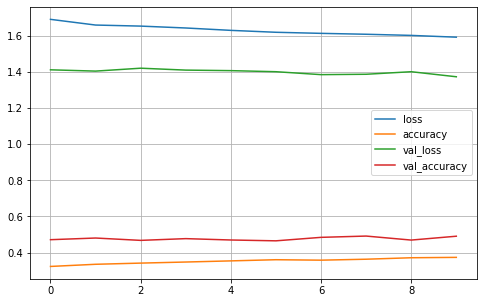

In [ ]:
# Plot the training loss and accuracy graph for model3 with augmentation
pd.DataFrame(model_history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
# obtaining train and test accuracy for the data augmented model3
X_test_norm_reshape= X_test_norm.reshape(-1, 48, 48, 1)
loss3_train, acc3_train = model3.evaluate(X_train_norm_reshape, y_train_norm, verbose=1)
print('Accuracy: %.3f' % acc3_train)
loss3_test, acc3_test = model3.evaluate(X_test_norm_reshape, y_test_norm, verbose=1)
print('Accuracy: %.3f' % acc3_test) 

# obtaining the confusion matrix for model 3 with data augumentation
y_proba3 = model3.predict(X_test_norm) 
y_pred3 = np.argmax(y_proba3,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred3, y_test_norm))
print('Classification Report')
print(classification_report(y_pred3, y_test_norm))

823/823 [==============================] - 4s 5ms/step - loss: 1.3447 - accuracy: 0.5073
Accuracy: 0.507
225/225 [==============================] - 1s 5ms/step - loss: 1.3690 - accuracy: 0.4930
Accuracy: 0.493
225/225 [==============================] - 1s 4ms/step
Confusion Matrix
[[ 245   27   68   32   83   92   27]
 [   0    0    0    0    0    0    0]
 [  72    7  132   27   39   69   53]
 [ 166   28  181 1443  210  228   69]
 [ 179   17  185   93  595  272   56]
 [ 227   29  257  118  236  546   48]
 [  69    3  201   61   70   40  578]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.26      0.43      0.32       574
         1.0       0.00      0.00      0.00         0
         2.0       0.13      0.33      0.19       399
         3.0       0.81      0.62      0.70      2325
         4.0       0.48      0.43      0.45      1397
         5.0       0.44      0.37      0.40      1461
         6.0       0.70      0.57      0.62      1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Early stopping. Model3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model3.fit(X_train_norm,y_train_norm, batch_size=10, epochs = 30, callbacks=[callback], validation_data=(X_val_norm,y_val_norm))

Epoch 1/30
2632/2632 [==============================] - 13s 5ms/step - loss: 1.2430 - accuracy: 0.5303 - val_loss: 1.2021 - val_accuracy: 0.5474
Epoch 2/30
2632/2632 [==============================] - 13s 5ms/step - loss: 1.2348 - accuracy: 0.5307 - val_loss: 1.2015 - val_accuracy: 0.5449
Epoch 3/30
2632/2632 [==============================] - 13s 5ms/step - loss: 1.2307 - accuracy: 0.5347 - val_loss: 1.1889 - val_accuracy: 0.5550
Epoch 4/30
2632/2632 [==============================] - 13s 5ms/step - loss: 1.2238 - accuracy: 0.5405 - val_loss: 1.1919 - val_accuracy: 0.5575
Epoch 5/30
2632/2632 [==============================] - 14s 5ms/step - loss: 1.2251 - accuracy: 0.5363 - val_loss: 1.1895 - val_accuracy: 0.5537
Epoch 6/30
2632/2632 [==============================] - 15s 6ms/step - loss: 1.2154 - accuracy: 0.5415 - val_loss: 1.1875 - val_accuracy: 0.5625
Epoch 7/30
2632/2632 [==============================] - 13s 5ms/step - loss: 1.2069 - accuracy: 0.5468 - val_loss: 1.1816 - val_ac

In [ ]:
# obtaining train and test accuracy for the data augmented model3
loss3_train, acc3_train = model3.evaluate(X_train_norm_reshape, y_train_norm, verbose=1)
print('Accuracy: %.3f' % acc3_train)
loss3_test, acc3_test = model3.evaluate(X_test_norm_reshape, y_test_norm, verbose=1)
print('Accuracy: %.3f' % acc3_test) 

# obtaining the confusion matrix for model 3 with data augumentation
y_proba3 = model3.predict(X_test_norm) 
y_pred3 = np.argmax(y_proba3,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred3, y_test_norm))
print('Classification Report')
print(classification_report(y_pred3, y_test_norm))

823/823 [==============================] - 4s 5ms/step - loss: 1.3447 - accuracy: 0.5073
Accuracy: 0.507
225/225 [==============================] - 1s 4ms/step - loss: 1.3690 - accuracy: 0.4930
Accuracy: 0.493
225/225 [==============================] - 1s 4ms/step
Confusion Matrix
[[ 245   27   68   32   83   92   27]
 [   0    0    0    0    0    0    0]
 [  72    7  132   27   39   69   53]
 [ 166   28  181 1443  210  228   69]
 [ 179   17  185   93  595  272   56]
 [ 227   29  257  118  236  546   48]
 [  69    3  201   61   70   40  578]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.26      0.43      0.32       574
         1.0       0.00      0.00      0.00         0
         2.0       0.13      0.33      0.19       399
         3.0       0.81      0.62      0.70      2325
         4.0       0.48      0.43      0.45      1397
         5.0       0.44      0.37      0.40      1461
         6.0       0.70      0.57      0.62      1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Used for pretrained Model 
X_train_color = np.repeat((x_train_data.astype('float32')/255.0).reshape(-1, 48, 48, 1), repeats=3, axis=3)
X_valid_color = np.repeat((x_val_data.astype('float32')/255.0).reshape(-1, 48, 48, 1), repeats=3, axis=3)
y_train_color = np_utils.to_categorical(y_train)
y_valid_color = np_utils.to_categorical(y_val)
print(X_train_color.shape)
print(X_valid_color.shape)
print(y_train_color.shape)
print(y_valid_color.shape)

(26316, 48, 48, 3)
(2393, 48, 48, 3)
(26316, 7)
(2393, 7)


58889256/58889256 [==============================] - 5s 0us/step


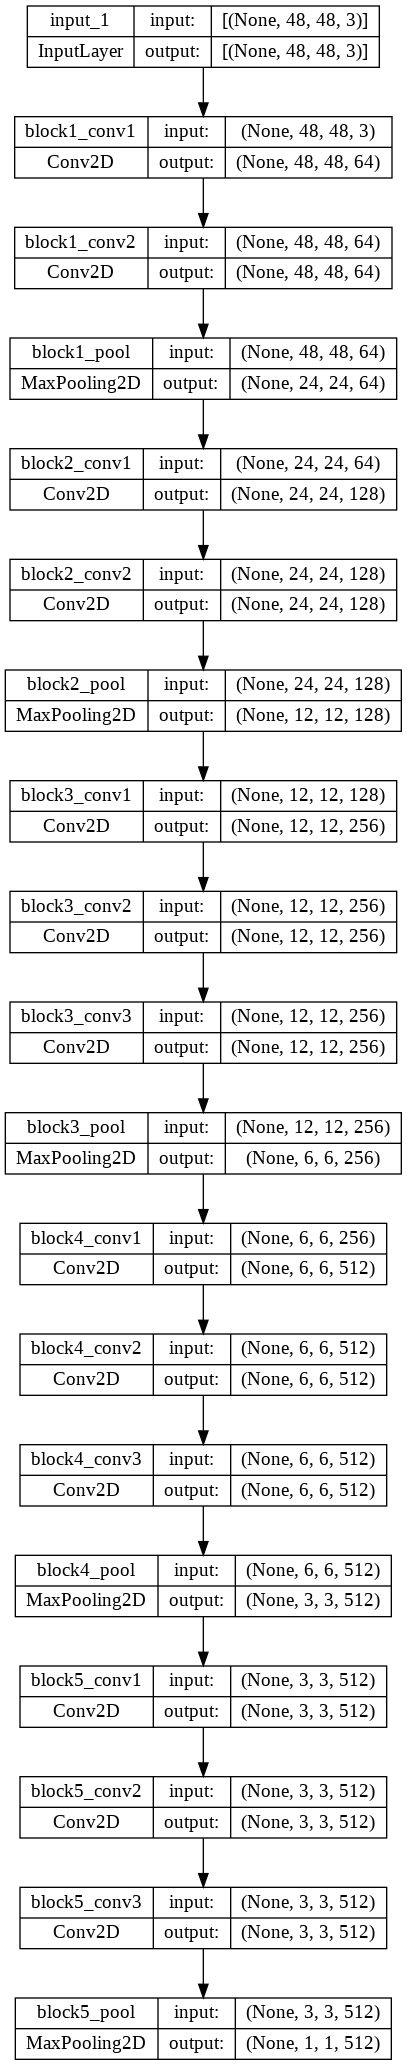

In [ ]:
# Using vgg16 as the pre trained model. 
base_model = tf.keras.applications.VGG16(
    input_shape = (48, 48, 3), 
    include_top = False, 
    weights = 'imagenet'
)
#Start with a non trainable model
base_model.trainable = False
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
# Adding few fully connected layers to the pre trained model to get our classified output.
np.random.seed(7)
tf.random.set_seed(7)
model_4 = keras.models.Sequential ([
    base_model,
    keras.layers.Flatten(),
    Dense(64, activation='relu'),
    keras.layers.Dropout(0.50),
    Dense(32, activation='relu'),
    keras.layers.Dropout(0.25),
    Dense(32, activation='relu'),
    keras.layers.Dropout(0.15),
    Dense(7, activation='softmax')
])
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

In [ ]:
# compiling the model_4 
#opt = tf.keras.optimizers.Adam(0.0001)
model_4.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
#training the network model_4
h1 = model_4.fit(
    X_train_color,y_train_color,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=10,
    validation_data=(X_valid_color,y_valid_color),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/10
411/411 [==============================] - 12s 26ms/step - loss: 1.7910 - accuracy: 0.2623 - val_loss: 1.6851 - val_accuracy: 0.3372
Epoch 2/10
411/411 [==============================] - 10s 24ms/step - loss: 1.7069 - accuracy: 0.3119 - val_loss: 1.6337 - val_accuracy: 0.3611
Epoch 3/10
411/411 [==============================] - 10s 25ms/step - loss: 1.6754 - accuracy: 0.3328 - val_loss: 1.6178 - val_accuracy: 0.3799
Epoch 4/10
411/411 [==============================] - 10s 24ms/step - loss: 1.6535 - accuracy: 0.3467 - val_loss: 1.6058 - val_accuracy: 0.3748
Epoch 5/10
411/411 [==============================] - 10s 25ms/step - loss: 1.6374 - accuracy: 0.3544 - val_loss: 1.5851 - val_accuracy: 0.3824
Epoch 6/10
411/411 [==============================] - 10s 24ms/step - loss: 1.6239 - accuracy: 0.3667 - val_loss: 1.5778 - val_accuracy: 0.3916
Epoch 7/10
411/411 [==============================] - 10s 24ms/step - loss: 1.6146 - accuracy: 0.3694 - val_loss: 1.5670 - val_accuracy:

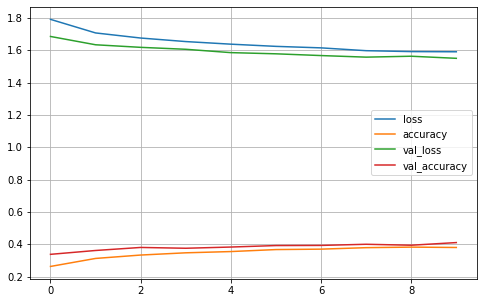

225/225 [==============================] - 4s 13ms/step
Confusion Matrix
[[ 245   27   68   32   83   92   27]
 [   0    0    0    0    0    0    0]
 [  72    7  132   27   39   69   53]
 [ 166   28  181 1443  210  228   69]
 [ 179   17  185   93  595  272   56]
 [ 227   29  257  118  236  546   48]
 [  69    3  201   61   70   40  578]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.26      0.43      0.32       574
         1.0       0.00      0.00      0.00         0
         2.0       0.13      0.33      0.19       399
         3.0       0.81      0.62      0.70      2325
         4.0       0.48      0.43      0.45      1397
         5.0       0.44      0.37      0.40      1461
         6.0       0.70      0.57      0.62      1022

    accuracy                           0.49      7178
   macro avg       0.40      0.39      0.38      7178
weighted avg       0.57      0.49      0.52      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_test_color=np.repeat((test_loaded_images.astype('float32')/255.0).reshape(-1, 48, 48, 1), repeats=3, axis=3)
y_test_color = np_utils.to_categorical(y_test)
data = model_4.history.history
pd.DataFrame(data).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
y_proba4 = model_4.predict(X_test_color) 
y_pred4 = np.argmax(y_proba3,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred4, y_test))
print('Classification Report')
print(classification_report(y_pred4, y_test))

In [ ]:
# implement the  trainable model
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.00001)
model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
h2 = model_4.fit(
    X_train_color,y_train_color,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=10,
    validation_data=(X_valid_color,y_valid_color),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/10
411/411 [==============================] - 28s 66ms/step - loss: 1.2522 - accuracy: 0.5328 - val_loss: 1.2187 - val_accuracy: 0.5700
Epoch 2/10
411/411 [==============================] - 27s 66ms/step - loss: 1.2203 - accuracy: 0.5444 - val_loss: 1.2112 - val_accuracy: 0.5825
Epoch 3/10
411/411 [==============================] - 27s 65ms/step - loss: 1.1965 - accuracy: 0.5559 - val_loss: 1.1863 - val_accuracy: 0.5926
Epoch 4/10
411/411 [==============================] - 27s 66ms/step - loss: 1.1434 - accuracy: 0.5779 - val_loss: 1.2380 - val_accuracy: 0.5830
Epoch 5/10
411/411 [==============================] - 27s 65ms/step - loss: 1.1194 - accuracy: 0.5846 - val_loss: 1.2133 - val_accuracy: 0.5758
Epoch 6/10
411/411 [==============================] - 27s 65ms/step - loss: 1.0830 - accuracy: 0.5999 - val_loss: 1.2022 - val_accuracy: 0.5800
Epoch 7/10
411/411 [==============================] - 27s 65ms/step - loss: 1.0527 - accuracy: 0.6170 - val_loss: 1.1615 - val_accuracy:

In [ ]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

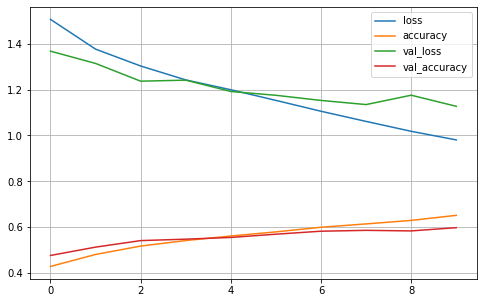

In [ ]:
data = model_4.history.history
pd.DataFrame(data).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [ ]:
y_proba4 = model_4.predict(X_test_color) 
y_pred4 = np.argmax(y_proba4,axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_pred4, y_test))
print('Classification Report')
print(classification_report(y_pred4, y_test))

225/225 [==============================] - 3s 12ms/step
Confusion Matrix
[[ 505   70  172   59   81  168   25]
 [   0    0    0    0    0    0    0]
 [  35    3  234   16   29   58   39]
 [ 111   12   70 1529  152  129   53]
 [ 104    7  118   72  696  197   37]
 [ 178   18  309   69  239  671   25]
 [  25    1  121   29   36   24  652]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.53      0.47      0.50      1080
         1.0       0.00      0.00      0.00         0
         2.0       0.23      0.57      0.33       414
         3.0       0.86      0.74      0.80      2056
         4.0       0.56      0.57      0.56      1231
         5.0       0.54      0.44      0.49      1509
         6.0       0.78      0.73      0.76       888

    accuracy                           0.60      7178
   macro avg       0.50      0.50      0.49      7178
weighted avg       0.65      0.60      0.62      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# obtaining train and test accuracy for the pretrained model
X_test_color=np.repeat((test_loaded_images.astype('float32')/255.0).reshape(-1, 48, 48, 1), repeats=3, axis=3)
y_test_color = np_utils.to_categorical(y_test)
print(X_test_color.shape)
loss4_train, acc4_train = model_4.evaluate(X_train_color, y_train_color, verbose=1)
print('Accuracy: %.3f' % acc4_train)
loss4_test, acc4_test = model_4.evaluate(X_test_color, y_test_color, verbose=1)
print('Accuracy: %.3f' % acc4_test) 

(7178, 48, 48, 3)
823/823 [==============================] - 12s 14ms/step - loss: 0.7178 - accuracy: 0.7747
Accuracy: 0.775
225/225 [==============================] - 3s 14ms/step - loss: 1.2198 - accuracy: 0.6062
Accuracy: 0.606


In [ ]:
#Used for pretrained Model 
X_train_color = np.repeat((x_train_data.astype('float32')/255.0).reshape(-1, 48, 48, 1), repeats=3, axis=3)
X_valid_color = np.repeat((x_val_data.astype('float32')/255.0).reshape(-1, 48, 48, 1), repeats=3, axis=3)
y_train_color = np_utils.to_categorical(y_train)
y_valid_color = np_utils.to_categorical(y_val)
print(X_train_color.shape)
print(X_valid_color.shape)
print(y_train_color.shape)
print(y_valid_color.shape)

(26316, 48, 48, 3)
(2393, 48, 48, 3)
(26316, 7)
(2393, 7)


In [ ]:
#Creating a CNN model. Model 5 for ensembing.
model_5 = keras.models.Sequential()
model_5.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape= (48,48,3), data_format='channels_last', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(keras.layers.Dropout(0.5))
model_5.add(Conv2D(2*64, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(keras.layers.Dropout(0.5))
model_5.add(Dense(300, activation='relu'))
model_5.add(keras.layers.Dropout(0.25))
model_5.add(keras.layers.Flatten())
model_5.add(Dense(7, activation='softmax'))
model_5.summary()
opt = tf.keras.optimizers.Adam(0.00001)
model_5.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
model_5.fit(X_train_color,y_train_color, batch_size=10, epochs = 24, validation_data=(X_valid_color,y_valid_color))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 11, 11, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 128)      

In [ ]:
# implement the  trainable model
# Adding few fully connected layers to the pre trained model to get our classified output.
# Using vgg16 as the pre trained model. 
base_model = tf.keras.applications.VGG16(
    input_shape = (48, 48, 3), 
    include_top = False, 
    weights = 'imagenet'
)

tf.keras.utils.plot_model(base_model, show_shapes=True)

np.random.seed(7)
tf.random.set_seed(7)
model_6 = keras.models.Sequential ([
    base_model,
    keras.layers.Flatten(),
    Dense(128, activation='relu'),
    keras.layers.Dropout(0.50),
    Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    Dense(32, activation='relu'),
    keras.layers.Dropout(0.15),
    Dense(7, activation='softmax')
])
model_6.summary()

base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.00001)
model_6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
h2 = model_6.fit(
    X_train_color,y_train_color,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=10,
    validation_data=(X_valid_color,y_valid_color),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)               

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

In [ ]:
# combining 2 models for ensembling
from tensorflow.keras.layers import Input, Average
models = [model_4, model_5]
model_input = Input(shape=(48, 48, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = WeightedAverageLayer(0.6, 0.4)(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
# train the emsemble network
ensemble_model.summary()
opt = tf.keras.optimizers.Adam(0.00001)

ensemble_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
ensemble_model.fit(X_train_color,y_train_color, batch_size=10, epochs = 24, validation_data=(X_valid_color,y_valid_color))

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 7)            14750887    ['input_7[0][0]']                
                                                                                                  
 sequential_7 (Sequential)      (None, 7)            184455      ['input_7[0][0]']                
                                                                                                  
 weighted_average_layer_1 (Weig  (None, 7)           0           ['sequential_2[0][0]',           
 htedAverageLayer)                                                'sequential_7[0][0]']    

In [ ]:
#obtain the val and test accuracy for ensemble model
print(X_test_color.shape)
loss5_train, acc5_train = ensemble_model.evaluate(X_train_color, y_train_color, verbose=1)
print('Accuracy: %.3f' % acc5_train)
loss5_test, acc5_test = ensemble_model.evaluate(X_test_color, y_test_color, verbose=1)
print('Accuracy: %.3f' % acc5_test)

(7178, 48, 48, 3)
823/823 [==============================] - 13s 15ms/step - loss: 0.6158 - accuracy: 0.8588
Accuracy: 0.859
225/225 [==============================] - 3s 15ms/step - loss: 1.1425 - accuracy: 0.6336
Accuracy: 0.634
